TP2

Mariana Chang Ieong 2074331

Zakarya Khnissi 198964

In [90]:
import numpy as np
import matplotlib.pyplot as py
from numpy import linalg as LA
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

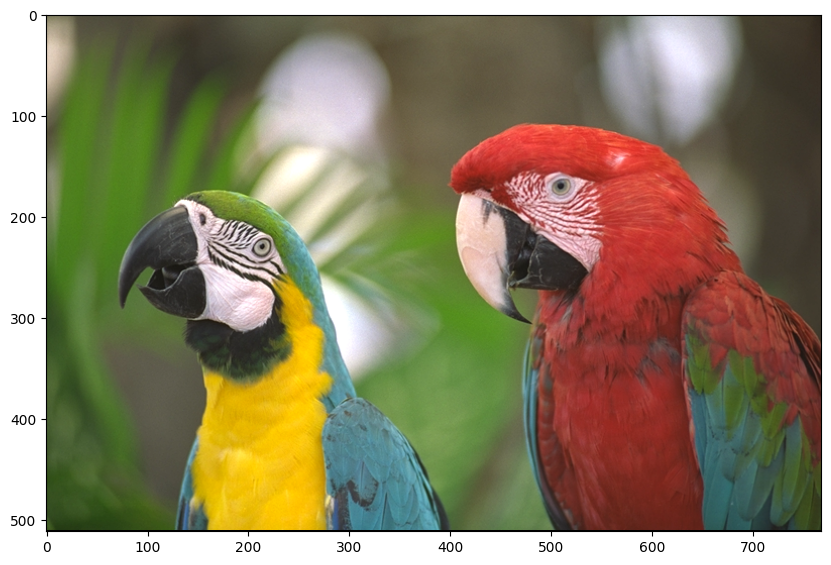

In [91]:
fig1 = py.figure(figsize = (10,10))
imagelue = py.imread('./images/kodim23.png')
image=imagelue.astype('double')
py.imshow(imagelue)
py.show()

Calcul des valeurs moyennes des RGB. Nécessaire pour calculer la matrice de covariance des RGB

In [92]:
sommeR = 0.0
sommeG = 0.0
sommeB = 0.0
for i in range(len(image)):
    for j in range(len(image[0])):
        sommeR=sommeR+image[i][j][0]
        sommeG=sommeG+image[i][j][1]
        sommeB=sommeB+image[i][j][2]
        
nbPixels = len(image)*len(image[0])        
MoyR= sommeR / nbPixels
MoyG= sommeG / nbPixels
MoyB= sommeB / nbPixels

print(MoyR)
print(MoyG)
print(MoyB)

0.47710636101046094
0.42978811898768754
0.29723136535832256


Calcul de la matrice de covariance des RGB

In [93]:
covRGB = np.zeros((3,3), dtype = "double")
for i in range(len(image)):
    for j in range(len(image[0])):
        vecTemp=[[image[i][j][0] - MoyR], [image[i][j][1]] - MoyG, [image[i][j][2] - MoyB]]
        vecProdTemp = np.dot(vecTemp,np.transpose(vecTemp))
        covRGB = np.add(covRGB,vecProdTemp)

covRGB = covRGB / nbPixels        
print(covRGB)

[[0.05075931 0.02759216 0.02004316]
 [0.02759216 0.03968838 0.02683971]
 [0.02004316 0.02683971 0.04420688]]


Calcul des vecteurs propres et valeurs propres

In [94]:
eigval, eigvec = LA.eig(covRGB)
print(eigval)
print()
print(eigvec)

[0.09466873 0.02744855 0.01253729]

[[-0.60995796 -0.71697239  0.33749351]
 [-0.57321392  0.1051337  -0.81263319]
 [-0.54715362  0.68912807  0.4751057 ]]


Pour illustrer les bénéfices du changement de repère, une composante sur trois sera supprimée dans le nouveau repère. a=Mb, où b est la composant RGB - la moyenne, M la matrice de transformation de repère, et a est la composante dans l'espace des vecteurs propres. 

In [95]:

def transformKL(image, eigvec, MoyR, MoyG, MoyB, quantifaction_vecteur):
    eigvec = np.transpose(eigvec)
    imageKL = np.copy(image)

    vecMoy =[[MoyR], [MoyG], [MoyB]] 


    for i in range(len(image)):
        for j in range(len(image[0])):
            vecTemp=[[image[i][j][0]], [image[i][j][1]], [image[i][j][2]]]
            #a=Mb
            imageKL[i][j][:] = np.reshape(np.dot(eigvec,np.subtract(vecTemp,vecMoy)),(3))

    max0 = np.amax(imageKL[:,:,0])
    min0 = np.amin(imageKL[:,:,0])
    max1 = np.amax(imageKL[:,:,1])
    min1 = np.amin(imageKL[:,:,1])
    max2 = np.amax(imageKL[:,:,2])
    min2 = np.amin(imageKL[:,:,2])

    step0 = (max0 - min0) / 2**quantifaction_vecteur[0]
    step1 = (max1 - min1) / 2**quantifaction_vecteur[1]
    step2 = (max2 - min2) / 2**quantifaction_vecteur[2]
    
    # Faire la quantification (8/8/4, etc.)
    for i in range(len(imageKL)):
        for j in range(len(imageKL[0])):
            imageKL[i][j][0] = (imageKL[i][j][0] - min0) // step0 * step0 + min0
            imageKL[i][j][1] = (imageKL[i][j][1] - min1) // step1 * step1 + min1
            imageKL[i][j][2] = (imageKL[i][j][2] - min2) // step2 * step2 + min2

    return imageKL
        
#step = plus grande valeur - plus petite valeur / 2^nbBits	

#question 2
# creer une fonction avec nom du fichier, choix de lespace colorimetrique, quantification
# pour 8/8/4, en gros on veut diviser en 2^4 niveaux, soit 16 niveaux, donc on voudrais diviser l'intervalle [0,255] en 16 intervalles de taille 16
# 40 compressions car 8*5 = 40. on a deja 8/8/8, 8/8/4, 8/8/0, 8/8/4, il faut trouver la derniere quantification, soit 8/4/4

#question 3
# 25 compressions car 5*5 = 25. blabla copilot: on a deja 8/8/8, 8/8/4, 8/8/0, 8/8/4, 8/4/4, il faut trouver la derniere quantification, soit 8/4/0

Les images dans les repères définis par les vecteurs propres ne peuvent pas être affichées. Toutefois, en éliminant un axe, on a retiré 33% de l'information. Une composante vaut zéro. Exemple:

In [96]:
# print(imageKL[10][10][:])

En faisant la transformée inverse, on peut voir les images qui résultent de la compression. b=inv(M)a. Dans le code, on utilse pinv (Pseudo-inverse), car la matrice est parfois singulière. Il faut faire b + moyenne.

In [97]:
def transformInverseKL(imageKL, eigvec, MoyR, MoyG, MoyB):
    eigvec = LA.pinv(np.transpose(eigvec))
    imageOutput = np.copy(image)
    vecMoy = [MoyR, MoyG, MoyB]

    for i in range(len(image)):
        for j in range(len(image[0])):
            # b = inv(M) * a
            vecTemp = [[imageKL[i][j][0]], [imageKL[i][j][1]], [imageKL[i][j][2]]]
            
            imageOutput[i][j][:] = np.add(np.reshape(np.dot(eigvec, vecTemp), (3)), vecMoy)
    return imageOutput

In [98]:
def rgb2gray(rgb):
    return np.dot(rgb[:,:], [0.299, 0.587, 0.114])

In [99]:
def calculatePSNR(image, eigvec, MoyR, MoyG, MoyB, quantification):
    imageKL = transformKL(image, eigvec, MoyR, MoyG, MoyB, quantification)
    imageOutput = transformInverseKL(imageKL, eigvec, MoyR, MoyG, MoyB)
    imageOutput = imageOutput.astype('uint8')
    return peak_signal_noise_ratio(image, imageOutput)

def calculateSSIM(image, eigvec, MoyR, MoyG, MoyB, quantification):
    imageKL = transformKL(image, eigvec, MoyR, MoyG, MoyB, quantification)
    imageOutput = transformInverseKL(imageKL, eigvec, MoyR, MoyG, MoyB)
    imageOutput = imageOutput.astype('uint8')
    return structural_similarity(image, imageOutput)

def calculateCompressionRate(quantification):
    return 1 - sum(quantification[0], quantification[1], quantification[2]) / 24

In [100]:
def showPicture(image, eigvec, MoyR, MoyG, MoyB, quantification):
    imageKL = transformKL(image, eigvec, MoyR, MoyG, MoyB, quantification)
    imageOutput = transformInverseKL(imageKL, eigvec, MoyR, MoyG, MoyB)
    imageOutput = imageOutput.astype('uint8')
    py.imshow(image)
    py.show()
    image = rgb2gray(image)
    imageOutput = rgb2gray(imageOutput)

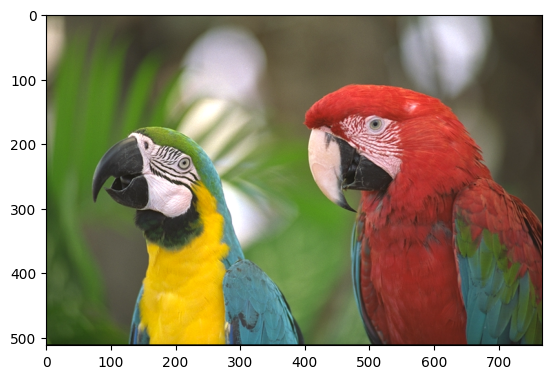

In [101]:
showPicture(image, eigvec, MoyR, MoyG, MoyB, [8,8,8])
# print(calculatePSNR(image, eigvec, MoyR, MoyG, MoyB, [8,8,0]))
# print(calculateSSIM(image, eigvec, MoyR, MoyG, MoyB, [8,8,0]))

Résultat sans l'axe de moyenne énergie. L'image assez dégradée. 8/0/8

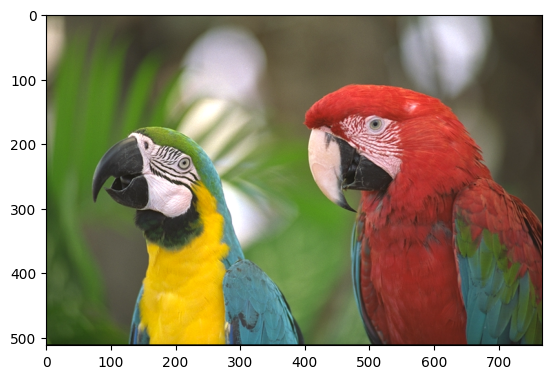

In [103]:
showPicture(image, eigvec, MoyR, MoyG, MoyB, [8,0,8])

Résultat sans l'axe de faible énergie. L'impact sur l'image est minime. 8/8/0

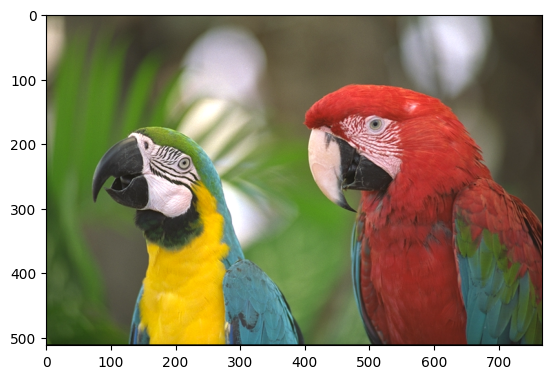

In [102]:
showPicture(image, eigvec, MoyR, MoyG, MoyB, [8,8,0])